## Import

In [ ]:
# Essential libraries
import pandas as pd
import numpy as np
import math 
import time
import itertools

# Dataset extraction
import requests
import zipfile
import os

# Dataset preparation
from splitfolders import ratio # to split the data into train and test (80/20)
from shutil import rmtree # to delete the extra empty validation folder

# Machine Learning
import keras

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential 
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical

# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Preparation

In [ ]:
# Dataset Download Link
url = "https://drive.google.com/u/0/uc?id=1L1JONuGRwtdeGCYYQjBqL_fgB9l__R8Q&export=download&confirm=t&uuid=7a3ad11a-709f-4be3-8dbc-b4edb55a5790&at=ANzk5s54Hw9PRCnpMaDOJyIMQ9Ik:1679758729349"

# Gets the file and downloads it
r = requests.get(url, allow_redirects=True)
open('vehicle_classification.zip', 'wb').write(r.content)

# Extracts the zip file
with zipfile.ZipFile('vehicle_classification.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Deletes the zip file
os.remove('vehicle_classification.zip')

In [32]:
# Divide the dataset into train and test
ratio('vehicle_classification', output="split-dataset", seed=1337, ratio=(.8,0, .2))

# delete the extra empty validation folder
rmtree('split-dataset/val/')

In [29]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'split-dataset/train' 
test_data_dir = 'split-dataset/test'
 
# number of epochs to train model
epochs = 15

# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 

In [ ]:
# Only needs to run once to create the bottleneck .npy files
# Takes about 45 minutes to run
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)


In [32]:
# Only needs to run once to create the bottleneck .npy files
# Takes about 15 minutes to run
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test) 
 
np.save('bottleneck_features_test.npy', bottleneck_features_test)

Found 5280 images belonging to 8 classes.


C:\Users\iyereshan\AppData\Local\Temp\ipykernel_9836\1598233362.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)


In [3]:
#training data
generator_train = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_train.filenames) 
num_classes = len(generator_train.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_train.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)



Found 21098 images belonging to 8 classes.


In [4]:
#testing data
generator_test = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_test.filenames) 
num_classes = len(generator_test.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('bottleneck_features_test.npy') 
 
# get the class labels for the testing data, in the original order 
test_labels = generator_test.classes 
 
# convert the testing labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 5280 images belonging to 8 classes.


## Model

In [30]:
# Only needs to be run once
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(learning_rate=1e-4),
   metrics=['acc'])

In [36]:
history = model.fit(train_data, train_labels, 
   epochs=epochs,
   batch_size=batch_size, validation_data=(test_data, test_labels))

# Prevents the need to retrain the model
model.save_weights(top_model_weights_path)

Epoch 1/15
422/422 [==============================] - 15s 32ms/step - loss: 0.9944 - acc: 0.6795 - val_loss: 0.6564 - val_acc: 0.7812
Epoch 2/15
422/422 [==============================] - 12s 28ms/step - loss: 0.7225 - acc: 0.7628 - val_loss: 0.6123 - val_acc: 0.7937
Epoch 3/15
422/422 [==============================] - 12s 27ms/step - loss: 0.6340 - acc: 0.7903 - val_loss: 0.5599 - val_acc: 0.8188
Epoch 4/15
422/422 [==============================] - 11s 27ms/step - loss: 0.5812 - acc: 0.8069 - val_loss: 0.5201 - val_acc: 0.8254
Epoch 5/15
422/422 [==============================] - 12s 28ms/step - loss: 0.5404 - acc: 0.8227 - val_loss: 0.5186 - val_acc: 0.8303
Epoch 6/15
422/422 [==============================] - 12s 29ms/step - loss: 0.5081 - acc: 0.8312 - val_loss: 0.5128 - val_acc: 0.8223
Epoch 7/15
422/422 [==============================] - 12s 28ms/step - loss: 0.4771 - acc: 0.8389 - val_loss: 0.4917 - val_acc: 0.8386
Epoch 8/15
422/422 [==============================] - 12s 28ms

In [31]:
# Loads the weights saved in the previous step
model.load_weights("bottleneck_fc_model.h5")

In [32]:
(test_loss, test_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
(train_loss, train_accuracy) = model.evaluate(train_data, train_labels, batch_size=batch_size, verbose=1)

# 90% accuracy on the test set and train set
print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print()
print("Train Loss: {:.2f}%".format(train_loss * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

422/422 [==============================] - 6s 14ms/step - loss: 0.2286 - acc: 0.9248
Train Accuracy: 92.48%
Test Accuracy: 84.75%

Train Loss: 22.86%
Test Loss: 46.88%


## Visualization

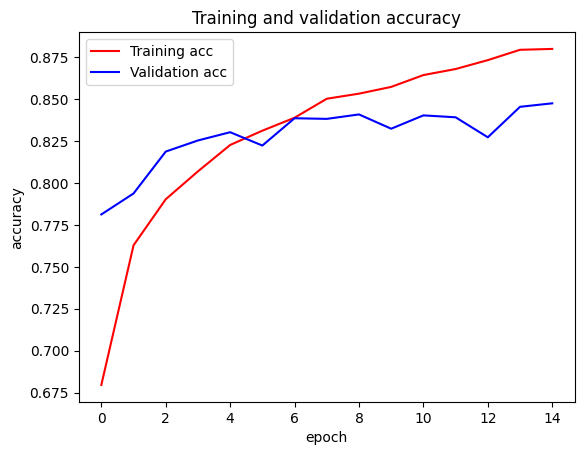

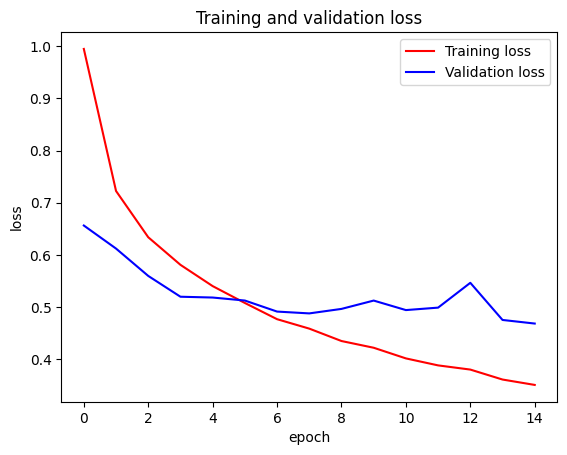

In [53]:
#Graphing our training and validation over the epochs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [33]:
preds = np.round(model.predict(test_data), 0)

165/165 [==============================] - 1s 6ms/step


In [34]:
vehicles = ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']
classification_metrics = metrics.classification_report(test_labels, preds,target_names=vehicles )
print(classification_metrics)

              precision    recall  f1-score   support

     Bicycle       0.90      0.73      0.81       324
         Bus       0.88      0.81      0.84       427
         Car       0.77      0.85      0.81      1357
  Motorcycle       0.84      0.86      0.85       598
 NonVehicles       0.99      1.00      1.00      1794
        Taxi       0.71      0.39      0.50       150
       Truck       0.77      0.38      0.51       407
         Van       0.74      0.39      0.51       223

   micro avg       0.87      0.82      0.85      5280
   macro avg       0.83      0.67      0.73      5280
weighted avg       0.87      0.82      0.84      5280
 samples avg       0.82      0.82      0.82      5280



c:\Users\iyereshan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

cm = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Greens):
 
#Add Normalization Option
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

Normalized confusion matrix


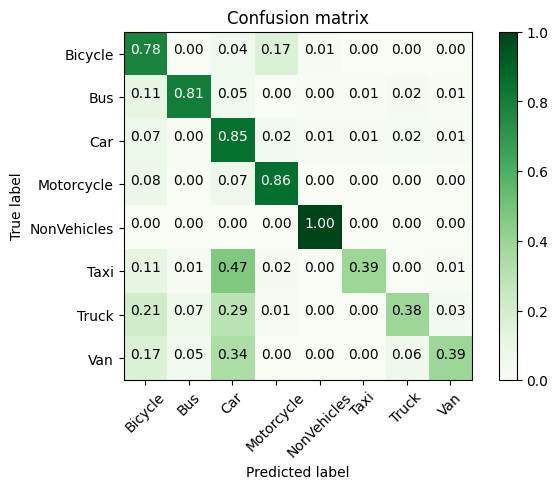

In [44]:
plot_confusion_matrix(cm, vehicles, normalize=True)

## Prediction

In [45]:
def read_image(file_path):
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

def test_single_image(path):
  percent_list = []
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict(bt_prediction)
  for idx, vechile, x in zip(range(0,8), vehicles , preds[0]):
    percent_list.append(round(x*100,2))
  return percent_list

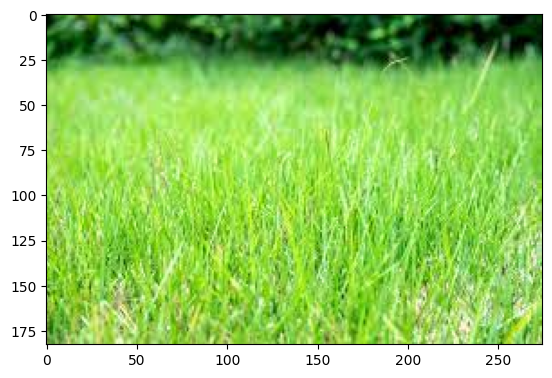

1/1 [==============================] - 0s 66ms/step
Prediction: NonVehicles


,Vechicles,Percent Chance
0,Bicycle,0.02
1,Bus,0.00
2,Car,0.00
3,Motorcycle,0.00
4,NonVehicles,99.97
5,Taxi,0.00
6,Truck,0.00
7,Van,0.00


In [46]:
# Plot image from directory
path = 'test-images/8.jpg'

img= mpimg.imread(path)
plt.imshow(img)
plt.show()

t = test_single_image(path)

vechiles = ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']

# Create a dataframe of the results
d = {'Vechicles': vechiles, 'Percent Chance': t}
df = pd.DataFrame(data=d)

print(f"Prediction: {(df.loc[df['Percent Chance'].idxmax()])['Vechicles']}")
df